In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sys
import cartopy.crs as ccrs
import xesmf
import datetime

In [2]:
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
sys.path.append(r'modules')

In [3]:
import constants

In [4]:
UKESM_PATH = '/g/data/w40/ab2313/PhD/UKESM1_longrun_4xCO2'

In [5]:
os.listdir(UKESM_PATH)

['bb446_pr.nc',
 'nemo_aw310o_1y_18571201-18581201_grid-T.nc',
 'anaylsis_01.ipynb',
 'aw310_pr.nc',
 'bb446_toa.nc',
 'aw310_tas.nc',
 '.ipynb_checkpoints',
 'bb446_tas.nc',
 'aw310_toa.nc']

In [56]:
constants.EXPERIMENTS_TO_RUN

[{'variable': 'tas', 'mask': None, 'hemisphere': 'global'},
 {'variable': 'tas', 'mask': 'land', 'hemisphere': 'global'},
 {'variable': 'pr', 'mask': None, 'hemisphere': 'global'},
 {'variable': 'pr', 'mask': 'land', 'hemisphere': 'global'},
 {'variable': 'tos', 'mask': 'sea', 'hemisphere': 'global'},
 {'variable': 'surf', 'mask': 'sea', 'hemisphere': 'global'},
 {'variable': 'surf', 'mask': 'sea', 'hemisphere': 'northern_hemisphere'},
 {'variable': 'surf', 'mask': 'sea', 'hemisphere': 'southern_hemisphere'}]

In [6]:
variables = np.unique([f['variable'] for f in constants.EXPERIMENTS_TO_RUN])
variables

array(['pr', 'surf', 'tas', 'tos'], dtype='<U4')

In [54]:
variable = 'toa'#variables[3]#'tas' # 
variable

'tos'

In [45]:
TARGET_GRID_PATH = os.path.join(constants.LONGRUNMIP_DIR, variable, 'regrid')
TARGET_GRID_PATH

'/g/data/w40/ab2313/PhD/longrunmip/surf/regrid'

In [46]:
target_regrid_file

<xarray.Dataset>
Dimensions:  (time: 15252, lat: 72, lon: 144)
Coordinates:
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * time     (time) float64 2.006e+07 2.006e+07 ... 3.276e+07 3.276e+07
Data variables:
    pr       (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.7.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.0
    history:      Fri Sep 16 19:31:37 2016: cdo remapbil,mygrid pr_Amon_EC-EA...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.7.2 (http://mpimet.mpg.de/...

In [47]:
target_regrid_file = xr.open_dataset(os.path.join(TARGET_GRID_PATH, os.listdir(TARGET_GRID_PATH)[0]))[[variable]]
target_regrid_file

<xarray.Dataset>
Dimensions:  (year: 1000, lat: 72, lon: 144)
Coordinates:
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * year     (year) float64 1.0 2.0 3.0 4.0 5.0 ... 997.0 998.0 999.0 1e+03
Data variables:
    surf     (year, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.7.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.0
    history:      Wed Jun 29 15:57:21 2016: cdo remapbil,mygrid surf_HadCM3L_...
    CDO:          Climate Data Operators version 1.7.0 (http://mpimet.mpg.de/...

['bb446_pr.nc',
 'nemo_aw310o_1y_18571201-18581201_grid-T.nc',
 'anaylsis_01.ipynb',
 'aw310_pr.nc',
 'bb446_toa.nc',
 'aw310_tas.nc',
 '.ipynb_checkpoints',
 'bb446_tas.nc',
 'aw310_toa.nc']

In [48]:
# ALl the files that contain the name of the specific variable
ukesm_fnames = [f for f in os.listdir(UKESM_PATH) if variable in f]
ukesm_fnames

[]

In [49]:
sample_file = xr.open_dataset(os.path.join(UKESM_PATH, ukesm_fnames[0]))
sample_file

IndexError: list index out of range

In [28]:
# UKESM does not use the standard names. This dictionary is a map from the UKESM
# to the standard name used by the rest of the files in longrunmip.
RENAMING_MAP = {
    'tas': 'air_temperature',
     'pr':'precipitation_flux'
}

In [29]:
RENAMING_MAP[variable]

'precipitation_flux'

In [30]:
# Opening a sample file to create the regirdder
sample_file = sample_file[[RENAMING_MAP[variable]]].rename({RENAMING_MAP[variable]: variable})
sample_file

<xarray.Dataset>
Dimensions:                  (time: 1270, latitude: 144, longitude: 192)
Coordinates:
  * time                     (time) object 1851-06-01 00:00:00 ... 3120-06-01...
  * latitude                 (latitude) float32 -89.38 -88.12 ... 88.12 89.38
  * longitude                (longitude) float32 0.9375 2.812 ... 357.2 359.1
    forecast_period          (time) timedelta64[ns] ...
    forecast_reference_time  (time) object ...
Data variables:
    pr                       (time, latitude, longitude) float32 ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.9
    Conventions:  CF-1.7

In [31]:
REGRIDDING_METHOD_MAP = {'tas': 'bilinear', 'pr':'conservative'}

In [33]:
regridding_method = REGRIDDING_METHOD_MAP[variable]
regridding_method

'conservative'

In [34]:
# Only need to create the regridder once
regridder = xesmf.Regridder(sample_file, target_regrid_file, method=regridding_method, periodic=True)
regridder

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_144x192_72x144.nc 
Reuse pre-computed weights? False 
Input grid shape:           (144, 192) 
Output grid shape:          (72, 144) 
Periodic in longitude?      False

In [35]:
regridded_sample_ds = regridder(sample_file)

In [36]:
np.testing.assert_equal(regridded_sample_ds.lat.values, target_regrid_file.lat.values)
np.testing.assert_equal(regridded_sample_ds.lon.values, target_regrid_file.lon.values)

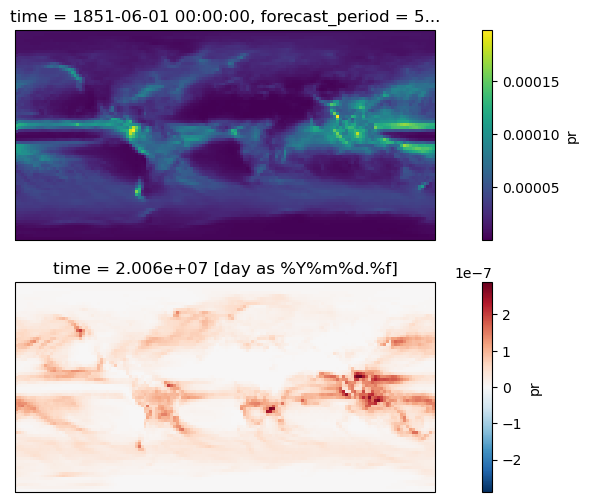

In [38]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(211, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(212, projection=ccrs.PlateCarree())
regridded_sample_ds[variable].isel(time=0).plot(ax=ax1)
target_regrid_file[variable].isel(time=0).plot(ax=ax2)

Regridd all files now

In [39]:
# THese are the code names used by Met Office for the 4xCo2 runs and the control runs.
control_code = 'aw310'
four_x_co2_code = 'bb446'

In [40]:
# Pedantic - want to save the file to the same place that I drew the data from 
OUTPUT_DIRECTORY = TARGET_GRID_PATH
OUTPUT_DIRECTORY

'/g/data/w40/ab2313/PhD/longrunmip/pr/regrid'

In [41]:
ukesm_fnames

['bb446_pr.nc', 'aw310_pr.nc']

In [42]:
for fname in ukesm_fnames:
    print(fname)
    ds = xr.open_dataset(os.path.join(UKESM_PATH, fname))#[['air_temperature']]
    
    # Checking that the time step is annual
    time_step = np.unique(np.diff(ds.time.values))[0]
    print(f'{time_step=}')
    assert  time_step > datetime.timedelta(days=300)
    
    # Regridding the file
    regridded_ds = regridder(ds)
    
    # Chekcking that the regrid has worked
    np.testing.assert_equal(regridded_ds.lat.values, target_regrid_file.lat.values)
    np.testing.assert_equal(regridded_ds.lon.values, target_regrid_file.lon.values)
        
    # Determing the name to save the file as. This should be inline with the file convention
    # from longrunmip (e.g. tas_ann_FAMOUS_abrupt4x_3000_g025.nc)
    fname_out = f'{variable}_ann_UKESM'
    fname_out = fname_out + '_abrupt4x' if four_x_co2_code in fname else fname_out + '_control'
    fname_out = fname_out + '.nc'
    print(f'{fname_out=}')
    regridded_ds.to_netcdf(os.path.join(OUTPUT_DIRECTORY, fname_out))
    print('\n')

bb446_pr.nc
time_step=datetime.timedelta(days=360)
fname_out='pr_ann_UKESM_abrupt4x.nc'


aw310_pr.nc
time_step=datetime.timedelta(days=360)
fname_out='pr_ann_UKESM_control.nc'


